In [1]:
#Import Mods
import pandas as pd
import numpy as np

import glob

import matplotlib.pyplot as plt

import act
import metpy.calc as mpcalc
from metpy.units import units

from datetime import datetime
from datetime import timedelta

from PIL import Image, ImageDraw

In [2]:
#grab sinlge image used to create the mask
file = pd.read_csv("/lcrc/project/waggle/public_html/private/training_data/waggle_area510/mobotix/"
                "thermal/1618803166_000001_right_336x252_14bit.thermal.celsius.csv")

In [3]:
#Create image list by unpacking data from CSV and placing in correct spot.
image_array = []

for i in range(file.size):
    if i >= 6:
        data = file.values[i][0]
        data = data.split(';')
        array = np.array(data)
        array = array.astype(np.float)
        image_array.append(array)
        

In [4]:
#Create first mask list with threshold value.
mask_col1 = []
count = 0

for j in image_array:
    mask_row = []
    
    for k in range(len(j)):
        
        if k > 40 and k < 110:
        
            if count > 40 and count < 90:
                if j[k] > 7:
                    mask_row.append(1)
                else:
                    mask_row.append(0)

            else:
                 mask_row.append(0)
        else:
             mask_row.append(0)
                
    mask_col1.append(mask_row)
    count = count + 1

In [5]:
#Create second mask list with threshold value.
mask_col2 = []
count = 0

for j in image_array:
    mask_row = []
    
    for k in range(len(j)):
        
        if k > 250 and k < 300:
        
            if count > 50 and count < 100:
                if j[k] > 5:
                    mask_row.append(1)
                else:
                    mask_row.append(0)

            else:
                 mask_row.append(0)
        else:
             mask_row.append(0)
                
    mask_col2.append(mask_row)
    count = count + 1

In [6]:
#create mask array and a find x-y values of for desired area
mask_array1 = np.array(mask_col1)
x1, y1 = np.nonzero(mask_array1)


mask_array2 = np.array(mask_col2)
x2, y2 = np.nonzero(mask_array2)

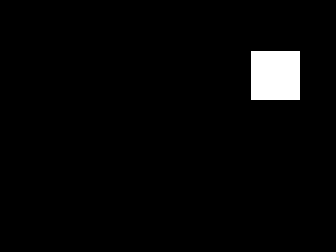

In [7]:
#Create image with with mask array
#This shape is a rectangle given the top left corner and botttom right corner
#shape1 = [(40, 40), (110, 90)]

shape2 = [(250, 50), (300, 100)]

#Tranform list into array and convert all true values from 1 to 255 as well as use an unsigned 8-bit integer dtype.
array = np.array(mask_col2).astype('uint8')*255

#create image
im = Image.fromarray(array)

#img1 = ImageDraw.Draw(im)
#img1.rectangle(shape2, fill = 150 , outline ="red")
im

In [8]:
#Grab ASOS data from nearest station.
time_window = [datetime(2021, 4, 16, 0, 0), datetime(2021, 4, 24, 3, 0)]
my_asoses = act.discovery.get_asos(time_window, station = 'LOT')
station = my_asoses['LOT']

Downloading: LOT


In [9]:
#Save off data that be used later
tempsf = station.tmpf.values
dewpsf = station.dwpf.values
time = station.time.values

In [10]:
#Grab files from directory and sort them into correct order
files = []
for filename in glob.glob("/lcrc/project/waggle/public_html/private/training_data/waggle_area510/mobotix/thermal/"
                          "*.thermal.celsius.csv"):
    files.append(filename)
files.sort()

In [11]:
#Run through all images and save off average temperature for each
temp_avg1 = []
temp_avg2 = []
image_count = []
image_time = []


for path in files:
    file = pd.read_csv(path)
    image_time.append(datetime.fromtimestamp(int(path[86:96])) + timedelta(hours = 5))
    image_array = []
    
    
    for i in range(file.size):
        if i >= 6:
            data = file.values[i][0]
            data = data.split(';')
            array = np.array(data)
            array = array.astype(np.float)
            image_array.append(array)
            
    image_array = np.array(image_array)
    
    temp_avg1.append(np.mean(image_array[x1, y1]))
    temp_avg2.append(np.mean(image_array[x2, y2]))

In [12]:
#Convert units from Celsius to Fahrenheit
temp_avgc1 = temp_avg1 * units.celsius
temp_avgf1 = temp_avgc1.to(units.fahrenheit)

temp_avgc2 = temp_avg2 * units.celsius
temp_avgf2 = temp_avgc2.to(units.fahrenheit)

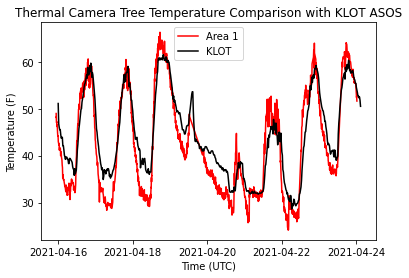

In [13]:
#Plot time series
plt.plot(image_time, temp_avgf1, color = 'red')
#plt.plot(image_time, temp_avgf2, color = 'blue')
plt.plot(time, tempsf, color='black')

plt.xlabel('Time (UTC)')
plt.xticks(time[np.arange(0, len(time), 144)])
plt.ylabel('Temperature (F)')

plt.title('Thermal Camera Tree Temperature Comparison with KLOT ASOS')

# Create a custom legend
plt.legend(['Area 1', 'KLOT'], loc = 'upper center')


#plt.savefig('Thermal_ASOS_Comparison_tree.png', transparent='true')